In [2]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import pdb
from sklearn.metrics import *
%matplotlib inline
import matplotlib.pyplot as plt

# Load dataset

In [2]:
genres_data = pd.read_csv(
    'movielens-dataset/u.genre', 
    sep = '|', 
    encoding = "ISO-8859-1", 
    header = None, 
    names=['name', 'id']
)

In [3]:
movie_data_columns = np.append(
    ['movie_id', 'title', 'release_date', 'video_release_date', 'url'], 
    genres_data['name'].values
)

In [4]:
movie_data = pd.read_csv(
    'movielens-dataset/u.item', 
    sep = '|', 
    encoding = "ISO-8859-1", 
    header = None, 
    names = movie_data_columns,
    index_col = 'movie_id'
)

In [5]:
selected_columns = np.append(['title', 'release_date'], genres_data['name'].values)
movie_data = movie_data[selected_columns]
movie_data['release_date'] = pd.to_datetime(movie_data['release_date'])

movie_data.head()

,title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995-01-01,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),1995-01-01,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),1995-01-01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),1995-01-01,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),1995-01-01,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
ratings_data = pd.read_csv(
    'movielens-dataset/u.data', 
    sep = '\t', 
    encoding = "ISO-8859-1", 
    header = None, 
    names=['user_id', 'movie_id', 'rating', 'timestamp']
)

In [7]:
movie_data['ratings_average'] = ratings_data.groupby(['movie_id'])['rating'].mean()
movie_data['ratings_count'] = ratings_data.groupby(['movie_id'])['rating'].count()

In [8]:
movie_data[['title', 'ratings_average', 'ratings_count']].head()

,title,ratings_average,ratings_count
movie_id,,,
1,Toy Story (1995),3.878319,452
2,GoldenEye (1995),3.206107,131
3,Four Rooms (1995),3.033333,90
4,Get Shorty (1995),3.550239,209
5,Copycat (1995),3.302326,86


# Remove null values

In [9]:
movie_data[selected_columns].isnull().any()

title           False
release_date     True
unknown         False
Action          False
Adventure       False
Animation       False
Children's      False
Comedy          False
Crime           False
Documentary     False
Drama           False
Fantasy         False
Film-Noir       False
Horror          False
Musical         False
Mystery         False
Romance         False
Sci-Fi          False
Thriller        False
War             False
Western         False
dtype: bool

In [10]:
null_release_dates = movie_data[movie_data['release_date'].isnull()]
assert null_release_dates.shape[0] == 1

In [11]:
movie_data = movie_data.drop(null_release_dates.index.values)
assert movie_data[selected_columns].isnull().any().any() == False

# Check data types

In [12]:
movie_data.dtypes

title                      object
release_date       datetime64[ns]
unknown                     int64
Action                      int64
Adventure                   int64
Animation                   int64
Children's                  int64
Comedy                      int64
Crime                       int64
Documentary                 int64
Drama                       int64
Fantasy                     int64
Film-Noir                   int64
Horror                      int64
Musical                     int64
Mystery                     int64
Romance                     int64
Sci-Fi                      int64
Thriller                    int64
War                         int64
Western                     int64
ratings_average           float64
ratings_count               int64
dtype: object

# Compute the artificial "price" and "buy_probability" attributes

In [13]:
from datetime import datetime
import dateutil

In [14]:
oldest_date = pd.to_datetime(movie_data['release_date']).min()
most_recent_date = pd.to_datetime(movie_data['release_date']).max()
normalised_age = (most_recent_date - pd.to_datetime(movie_data['release_date'])) / (most_recent_date - oldest_date)
normalised_rating = (5 - movie_data['ratings_average']) / (5 - 1)

movie_data['price'] = np.round((1 - normalised_rating) * (1 - normalised_age) * 10)
movie_data[['title', 'price', 'ratings_average', 'ratings_count']].head()

,title,price,ratings_average,ratings_count
movie_id,,,,
1,Toy Story (1995),7.0,3.878319,452
2,GoldenEye (1995),5.0,3.206107,131
3,Four Rooms (1995),5.0,3.033333,90
4,Get Shorty (1995),6.0,3.550239,209
5,Copycat (1995),5.0,3.302326,86


In [15]:
# one movie had title unknown, relesease data unknown, etc...
movie_data = movie_data[movie_data['price'].notnull()]

In [16]:
# the lower the price, the more likely I am going to buy
movie_data['buy_probability'] = 1 - movie_data['price'] * 0.1

# The perfect ranking

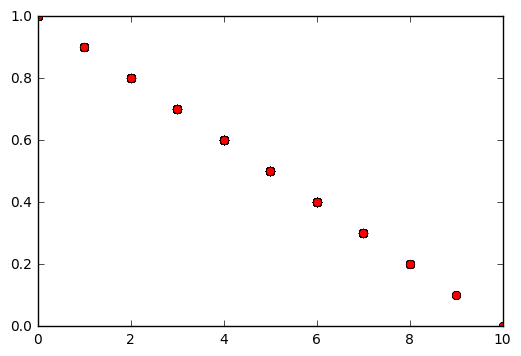

In [17]:
plt.plot(movie_data['price'].values, movie_data['buy_probability'].values, 'ro') # ro = red circles
plt.show()

## Genres distribution

In [18]:
genres_array = [(genre, movie_data[genre].sum()) for genre in genres_data['name'].values]
genres_names = list(map(lambda x: x[0], genres_array))
genres_count = list(map(lambda x: x[1], genres_array))

genres_df = pd.DataFrame({'name': genres_names, 'count': genres_count})
genres_df.head()

,count,name
0,1,unknown
1,251,Action
2,135,Adventure
3,42,Animation
4,122,Children's


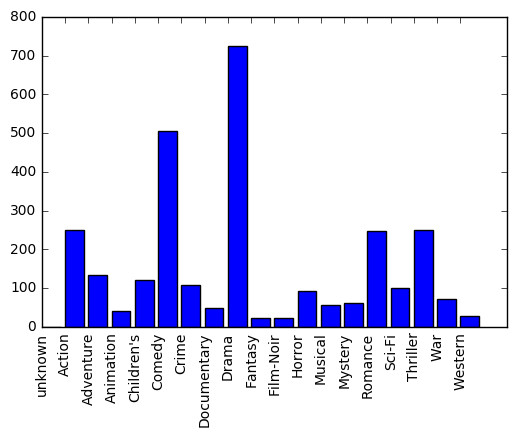

In [19]:
x = np.arange(len(genres_df['name'].values))
plt.bar(x, genres_df['count'].values)
plt.xticks(x, genres_df['name'].values, rotation='vertical')
plt.show()

## Release date distribution

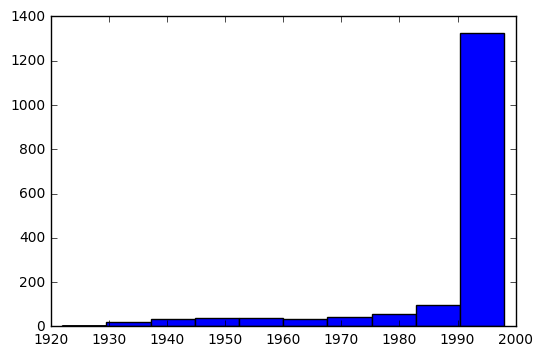

In [20]:
years = movie_data['release_date'].values.astype('datetime64[Y]').astype(int) + 1970
plt.hist(years)
plt.show()

## Ratings average distribution

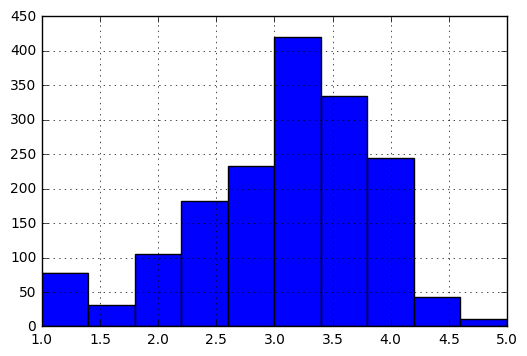

In [21]:
movie_data['ratings_average'].hist()

## Price

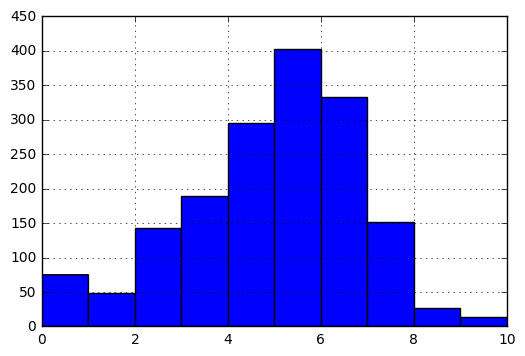

In [22]:
movie_data['price'].hist()

## Ratings count distribution

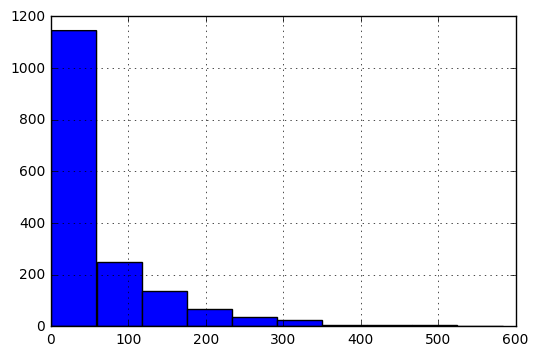

In [23]:
movie_data['ratings_count'].hist()

## Buy probability distribution

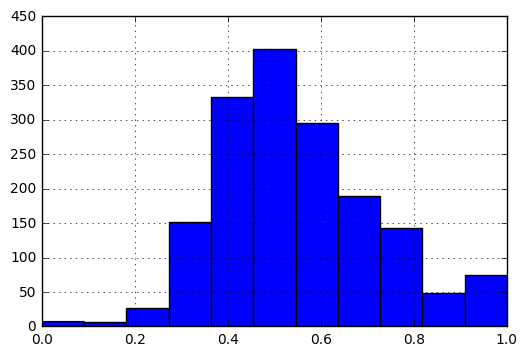

In [24]:
movie_data['buy_probability'].hist(bins=11)

# Events database

Each user has a certain probability of renting a movie. Let `X` the random variable being `1` if the user rented the movie and `0` otherwise.  

$$X \backsim Bernoulli(p)$$

where $p=f(movie~features)$.

In [27]:
np.random.seed(1)

In [28]:
# Saw a movie and ended up buying it
# [
#   user_1: [list of movies]
#   user_2: [list of movies]
#   ...
# ]
class PositiveEvents:
    def __init__(self):
        self.data = []
    
    def add(self, user_id, movie_id):
        self.data.append({'user_id': user_id, 'movie_id': movie_id})
    
    def all(self):
        return self.data

# Saw a movie but did not buy
# [
#   user_1: [list of movies]
#   user_2: [list of movies]
#   ...
# ]
class NegativeEvents:
    def __init__(self):
        self.data = []
        
    def add(self, user_id, movie_id):
        self.data.append({'user_id': user_id, 'movie_id': movie_id})
    
    def all(self):
        return self.data

# The users database
class Users:
    def __init__(self):
        self.data = []
        
    def add(self, user_id):
        self.data.append({'user_id': user_id})
    
    def all(self):
        return self.data

In [29]:
NUM_OF_OPENED_MOVIES_PER_USER = 20
NUM_OF_USERS = 20000

users = Users()
positive_events = PositiveEvents()
negative_events = NegativeEvents()

for id in range(1, NUM_OF_USERS):
    users.add(id)

for user in users.all():
    opened_movies = np.random.choice(movie_data.index.values, NUM_OF_OPENED_MOVIES_PER_USER)
    
    for movie_id in opened_movies:
        if np.random.binomial(1, movie_data.loc[movie_id].buy_probability): 
            positive_events.add(user['user_id'], movie_id)
        else:
            negative_events.add(user['user_id'], movie_id)

In [30]:
movie_data.shape

(1681, 25)

In [31]:
len(positive_events.all())

222185

In [32]:
len(negative_events.all())

177795

# Generates data for training/testing

In [25]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [26]:
movie_data.head(1)

,title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,ratings_average,ratings_count,price,buy_probability
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995-01-01,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,3.878319,452,7.0,0.3


In [27]:
feature_columns = np.setdiff1d(movie_data.columns, np.array(['title', 'buy_probability']))
feature_columns

array(['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
       'price', 'ratings_average', 'ratings_count', 'release_date',
       'unknown'], dtype=object)

In [28]:
learning_data = movie_data.loc[:, feature_columns]
learning_data.head(1)

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Romance,Sci-Fi,Thriller,War,Western,price,ratings_average,ratings_count,release_date,unknown
movie_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,7.0,3.878319,452,1995-01-01,0


In [29]:
scaler = StandardScaler()
learning_data.loc[:, ('price')] = scaler.fit_transform(learning_data[['price']])
learning_data['ratings_average'] = scaler.fit_transform(learning_data[['ratings_average']])
learning_data['ratings_count'] = scaler.fit_transform(learning_data[['ratings_count']])
learning_data['release_date'] = learning_data['release_date'].apply(lambda x: x.year)
learning_data['release_date'] = scaler.fit_transform(learning_data[['release_date']])

learning_data.head(1)

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Romance,Sci-Fi,Thriller,War,Western,price,ratings_average,ratings_count,release_date,unknown
movie_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,1.344357,1.026718,4.883605,0.393978,0


# Create the events for learning

In [38]:
events_data = []

for event in positive_events.all():
    tmp = learning_data.loc[event['movie_id']].to_dict()
    tmp['outcome'] = 1
    events_data += [tmp]

for event in negative_events.all():
    tmp = learning_data.loc[event['movie_id']].to_dict()
    tmp['outcome'] = 0
    events_data += [tmp]

events_data = pd.DataFrame(events_data)
events_data.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Sci-Fi,Thriller,War,Western,outcome,price,ratings_average,ratings_count,release_date,unknown
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,-1.307443,-1.376422,-0.715191,0.534335,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,-2.368163,-2.655833,-0.727633,0.604514,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,-0.246723,-0.459109,-0.080661,0.043084,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0.283637,0.069868,-0.453914,0.253620,0
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,1,-0.777083,1.108383,0.765380,-2.483349,0


In [39]:
for genre in genres_data['name'].values:
    events_data[genre] = events_data[genre].astype(int)
    
events_data.dtypes

Action               int64
Adventure            int64
Animation            int64
Children's           int64
Comedy               int64
Crime                int64
Documentary          int64
Drama                int64
Fantasy              int64
Film-Noir            int64
Horror               int64
Musical              int64
Mystery              int64
Romance              int64
Sci-Fi               int64
Thriller             int64
War                  int64
Western              int64
outcome              int64
price              float64
ratings_average    float64
ratings_count      float64
release_date       float64
unknown              int64
dtype: object

# Events distributions

In [117]:
events_data_sample = events_data.sample(frac=0.1)

In [136]:
negative_outcomes = events_data_sample[events_data_sample['outcome'] == 0.0]['price']
positive_outcomes = events_data_sample[events_data_sample['outcome'] == 1.0]['price']

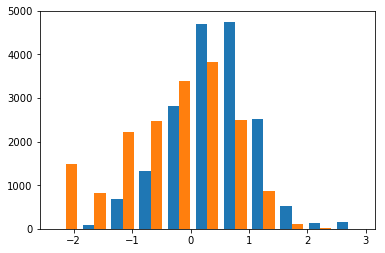

In [148]:
outcomes = np.array(list(zip(negative_outcomes.values, positive_outcomes.values)))
plt.hist(outcomes, bins=11)
plt.show()

# Save events to CSV for external processing

In [42]:
events_data = events_data.reindex(np.random.permutation(events_data.index))
events_data.to_csv('movie_events.csv')

In [34]:
df = pd.DataFrame(feature_columns)
df.to_csv("feature_columns.csv")

# Load events from CSV

In [3]:
events_data = pd.DataFrame.from_csv('movie_events.csv')
events_data.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Sci-Fi,Thriller,War,Western,outcome,price,ratings_average,ratings_count,release_date,unknown
83349,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,-0.777083,-0.867410,0.417010,0.464156,0
68144,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,-0.246723,-0.310247,-0.665424,0.323799,0
344645,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,-0.246723,0.714322,0.280151,-1.149954,0
71975,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,-1.307443,-1.725353,-0.603215,0.253620,0
208783,0,0,0,1,1,0,0,0,1,0,...,0,0,0,0,1,-0.246723,-0.410829,-0.080661,0.534335,0


In [4]:
tmp = pd.DataFrame.from_csv('feature_columns.csv')
feature_columns = tmp['0'].values
feature_columns

array(['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
       'price', 'ratings_average', 'ratings_count', 'release_date',
       'unknown'], dtype=object)

# Train/Test data split

In [5]:
X = events_data.loc[:, feature_columns].values
print('overall input shape: ' + str(X.shape))

y = events_data.loc[:, ['outcome']].values.ravel()
print('overall output shape: ' + str(y.shape))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('training input shape: ' + str(X_train.shape))
print('training output shape: ' + str(y_train.shape))

print('testing input shape: ' + str(X_test.shape))
print('testing output shape: ' + str(y_test.shape))

overall input shape: (399980, 23)
overall output shape: (399980,)
training input shape: (319984, 23)
training output shape: (319984,)
testing input shape: (79996, 23)
testing output shape: (79996,)


# Ranking with Amazon ML

![title](amazon_performance.png)

# The perfect predictor

In [105]:
class PerfectPredictor:
    def __init__(self, prices):
        price = X_train[:, -5]
        max_price = np.max(prices)
        min_price = np.min(prices)

        self.norm_prices = [ (x - min_price)/(max_price - min_price) for x in prices ]
    
    def predict(self, X):
        return [self.predict_one(i, x) for i, x in enumerate(X)]
            
    def predict_one(self, i, x):
        if self.norm_prices[i] > 0.5:
            return 1
        else:
            return 0

In [106]:
p = PerfectPredictor(X_train[:, -5])

In [107]:
y_train_pred = p.predict(X_train)

print('train precision: ' + str(precision_score(y_train, y_train_pred)))
print('train recall: ' + str(recall_score(y_train, y_train_pred)))
print('train accuracy: ' + str(accuracy_score(y_train, y_train_pred)))

train precision: 0.351595983815
train recall: 0.198007156682
train accuracy: 0.351701960098


In [108]:
y_test_pred = p.predict(X_test)

print('test precision: ' + str(precision_score(y_test, y_test_pred)))
print('test recall: ' + str(recall_score(y_test, y_test_pred)))
print('test accuracy: ' + str(accuracy_score(y_test, y_test_pred)))

test precision: 0.552117329465
test recall: 0.308285900695
test accuracy: 0.476698834942


# Rank with a Logistic Regression

* Collect for each movie the buy probability from the raw events
* Run a beta regression

=> Expect the coefficients to represent the artificial probability function

In [39]:
l = LogisticRegression()
l.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [40]:
y_train_pred = l.predict(X_train)

print('train precision: ' + str(precision_score(y_train, y_train_pred)))
print('train recall: ' + str(recall_score(y_train, y_train_pred)))
print('train accuracy: ' + str(accuracy_score(y_train, y_train_pred)))

train precision: 0.665267528143
train recall: 0.737470180492
train accuracy: 0.648069903495


In [41]:
y_test_pred = l.predict(X_test)

print('test precision: ' + str(precision_score(y_test, y_test_pred)))
print('test recall: ' + str(recall_score(y_test, y_test_pred)))
print('test accuracy: ' + str(accuracy_score(y_test, y_test_pred)))

test precision: 0.66292225798
test recall: 0.736866971135
test accuracy: 0.645607280364


# Rank with a Neural Network

* Input each event to the Neural network
* Train the network
* Run the prediction on the training set

=> Expect the order of the results to represent the artificial probability function

In [5]:
import logging
fh = logging.FileHandler('output.log')

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
#logger.removeHandler(logger.handlers[0])
logger.addHandler(fh)

In [6]:
from sknn.platform import cpu32, threading
from sknn.mlp import Regressor, Layer

nn = Regressor(
    layers=[
        Layer("Sigmoid", units=feature_columns.size),
        Layer("Linear")],
    learning_rate=0.1,
    n_iter=20, 
    n_stable=5)

nn.fit(X_train, y_train)

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


KeyboardInterrupt: 

In [11]:
y_train_pred = np.rint(nn.predict(X_train))
print('train precision: ' + str(precision_score(y_train, y_train_pred)))
print('train recall: ' + str(recall_score(y_train, y_train_pred)))
print('train accuracy: ' + str(accuracy_score(y_train, y_train_pred)))

train precision: 0.651653232136
train recall: 0.79274826738
train accuracy: 0.648869943497


In [12]:
y_test_pred = np.rint(nn.predict(X_test))

print('test precision: ' + str(precision_score(y_test, y_test_pred)))
print('test recall: ' + str(recall_score(y_test, y_test_pred)))
print('test accuracy: ' + str(accuracy_score(y_test, y_test_pred)))

test precision: 0.644568542888
test recall: 0.792481475607
test accuracy: 0.644444722236


In [48]:
ranking_input = learning_data.values
print('overall input shape: ' + str(ranking_input.shape))
learning_data['rank'] = nn.predict(ranking_input)

overall input shape: (1681, 23)


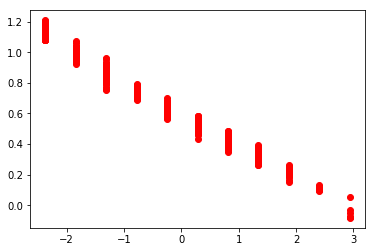

In [55]:
plt.plot(learning_data['price'].values, learning_data['rank'].values, 'ro')
plt.show()

# Neural Network in NoLearn

In [1]:
from lasagne import layers
from lasagne.updates import nesterov_momentum
from lasagne.nonlinearities import softmax
from nolearn.lasagne import NeuralNet

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 23),  # this code won't compile without SIZE being set
    hidden_num_units=46,  # number of units in hidden layer
    output_nonlinearity=softmax,  # output layer uses identity function
    output_num_units=1,  # this code won't compile without OUTPUTS being set

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01, 
    update_momentum=0.9, 

    regression=True,  # If you're doing classification you want this off
    max_epochs=20,  # more epochs can be good, 
    verbose=1, # enabled so that you see meaningful output when the program runs
)

net1.fit(X_train.astype(np.float32), y_train.astype(np.float32))

# Neural Network with 1151 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input       23
  1  hidden      46
  2  output       1

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.44382     0.44249    1.00301  0.63s
      2     0.44382     0.44249    1.00301  0.59s
      3     0.44382     0.44249    1.00301  0.59s
      4     0.44382     0.44249    1.00301  0.76s
      5     0.44382     0.44249    1.00301  0.59s
      6     0.44382     0.44249    1.00301  0.59s
      7     0.44382     0.44249    1.00301  0.67s
      8     0.44382     0.44249    1.00301  0.60s
      9     0.44382     0.44249    1.00301  0.59s
     10     0.44382     0.44249    1.00301  0.59s
     11     0.44382     0.44249    1.00301  0.59s
     12     0.44382     0.44249    1.00301  0.59s
     13     0.44382     0.44249    1.00301  0.59s
     14     0.44382     0.44249    1.00301  0.59s
     15     0.44382     0.4424

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f6d5f96a710>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f6d5f96a630>,
     check_input=True, custom_scores=None, hidden_num_units=46,
     input_shape=(None, 23),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=20, more_params={},
     objective=<function objective at 0x7f6d29825c80>,
     objective_loss_function=<function squared_error at 0x7f6d2b0b0a60>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog object at 0x7f6d1f6f97b8>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo object at 0x7f6d1f6f97f0>],
     output_nonlinearity=<function softmax at 0x7f6d2e0b0598>,
     output_num_units=1, regression=True, sco